In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, linregress
import os
from datetime import datetime
import sys
sys.path.append('/home/wallacelab/complexity-final/Optimizations')

import optimization_diff

In [2]:
# Parameters
num_simulations = 1  # Number of simulations to run
task_name = "complexity_prediction"

# Dynamically generate predictor column names '0' through '48'
predictor_columns = [str(i) for i in range(49)]

all_weights = []
spearman_rhos = []

Results will be saved in: ./optimization_results_20241127_155649
Starting optimization without cross-validation...
Calculating initial Spearman correlations for each predictor...
Predictor 0: Initial Spearman rho = -0.06553367297135648
Predictor 1: Initial Spearman rho = -0.05240118840735185
Predictor 2: Initial Spearman rho = 0.07016866752335811
Predictor 3: Initial Spearman rho = 0.12553110245004434
Predictor 4: Initial Spearman rho = -0.0392687038433472
Predictor 5: Initial Spearman rho = -0.018926227754006687
Predictor 6: Initial Spearman rho = 0.13196859488337995
Predictor 7: Initial Spearman rho = 0.32856961379744937
Predictor 8: Initial Spearman rho = 0.10827862272870492
Predictor 9: Initial Spearman rho = -0.01686623017533929
Predictor 10: Initial Spearman rho = -0.14600232838805155
Predictor 11: Initial Spearman rho = 0.37981205356680076
Predictor 12: Initial Spearman rho = -0.12874984866671213
Predictor 13: Initial Spearman rho = -0.030384964285344065
Predictor 14: Initial Sp

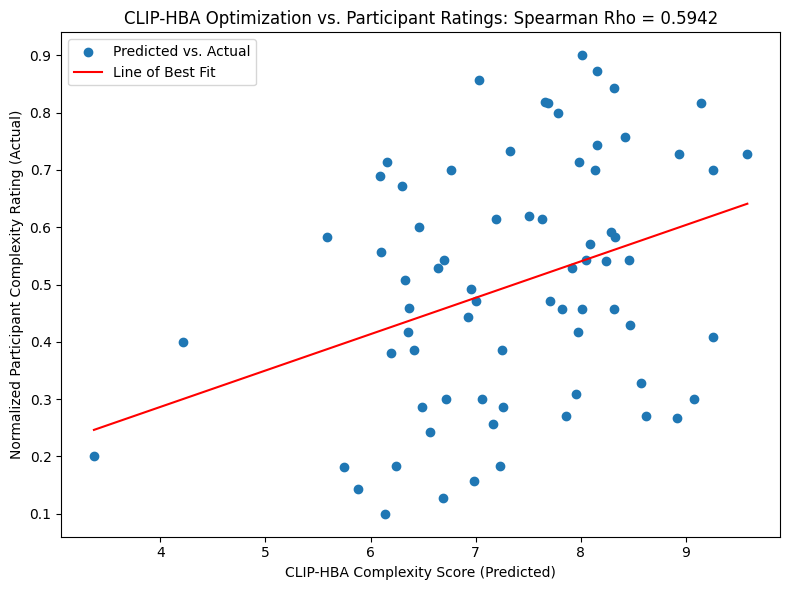

In [3]:
# Run the simulation multiple times
for _ in range(num_simulations):
    # Load your data (ensure these paths are correct)
    df1 = pd.read_csv('/home/wallacelab/complexity-final/ExperimentData/ambiguous_choice_results.csv')
    df2 = pd.read_csv('/home/wallacelab/complexity-final/Embeddings/CLIP-HBA/Dora49/Ambiguous/static_embedding.csv')
    
    # Run the bayesian optimization function (make sure it's defined in this notebook or imported)
    best_weights, best_rho = optimization_diff.bayesian_optimization_fit(df1, df2, predictor_columns, task_name=task_name, cross_validate=False)
    all_weights.append(best_weights)
    spearman_rhos.append(best_rho)

# Find the best (highest) Spearman rho and corresponding weights
best_rho_index = np.argmax(spearman_rhos)
best_rho = spearman_rhos[best_rho_index]
best_weights = all_weights[best_rho_index]

# Calculate predictions for each image using the best weights
# Assuming `df2` contains predictor columns and `df1` contains the actual values
df1 = pd.read_csv('/home/wallacelab/complexity-final/ExperimentData/ambiguous_choice_results.csv')
df2 = pd.read_csv('/home/wallacelab/complexity-final/Embeddings/CLIP-HBA/Dora49/Ambiguous/static_embedding.csv')

# Ensure that df1 and df2 are aligned by merging on 'image' column if necessary
if 'image' in df1.columns and 'image' in df2.columns:
    combined_df = pd.merge(df1, df2, on='image')
    y_true = combined_df['Proportion of Participant Choice'].values
    X = combined_df[predictor_columns].values
else:
    y_true = df1['Proportion of Participant Choice'].values
    X = df2[predictor_columns].values

# Get predicted values by multiplying X by best weights
y_pred = X @ best_weights

# Calculate the line of best fit for predicted vs. actual
slope, intercept, _, _, _ = linregress(y_pred, y_true)  # Predicted (x) vs. Actual (y)
line_x = np.linspace(y_pred.min(), y_pred.max(), 100)  # Restrict line_x to the range of predicted values
line_y = slope * line_x + intercept  # Compute corresponding y values using the regression equation

# Plot the scatter plot and line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_true, label="Predicted vs. Actual")  # Predicted on x, Actual on y
plt.plot(line_x, line_y, color="red", label="Line of Best Fit")  # Best-fit line for predicted vs. actual
plt.xlabel("CLIP-HBA Complexity Score (Predicted)")
plt.ylabel("Normalized Participant Complexity Rating (Actual)")
plt.title(f"CLIP-HBA Optimization vs. Participant Ratings: Spearman Rho = {best_rho:.4f}")
plt.legend()
plt.tight_layout()
plt.show()